Exercise work consists of three parts. After each part, take the mini-exam available in Moodle. The questions concern the exercise so read the instructions carefully and make sure you remember to cover all given tasks. <br>
After the deadline of each mini-exam, example results will be published. This helps you to move to the next part. However, take into account that the deadlines are thus strict, no extensions will be granted! <br>
Two exam points can be acquired from each mini-exam. All three parts of the exercise are compulsory. Completed exercise work from previous years does not apply for this course.

**Deadlines for the mini-exams:**
- Part 1: Fri 9.2.2024 at 23:59
- Part 2: Fri 23.2024 at 23:59
- Part 3: Fri 8.3.2024 at 23:59

**If you encounter problems, Google first and if you can’t find an answer, ask for help**
- Moodle area for questions
- pekavir@utu.fi

**Grading**

The exercise covers a part of the grading in this course. The course exam has 5 questions, 6 points of each. Exercise gives at maximum 6 points, i.e. the total score is 36 points.

# Part 1

Read the original research article:

İ. Çınar and M. Koklu. Identification of rice varieties using machine learning algorithms. Journal of Agricultural Sciences, 28(2):307–325, 2022. doi: 10.15832/ankutbd.862482.

https://dergipark.org.tr/en/download/article-file/1513632

There will be questions regarding the article in the mini-exam.

## Introduction

Will be written in Part 3.

## Preparations of the data

Make three folders in your working folder: 'notebooks', 'data' and 'training_data'. Save this notebook in 'notebooks' folder.

Import all the packages needed for this notebook in one cell (add the ones you apply):

In [1]:
import numpy as np
import scipy.stats as sp
import pandas as pd
from random import sample
from random import seed
import glob, os
import cv2 as cv
import matplotlib.pyplot as plt

Import the images. Data can be found from (downloading starts as you press the link) https://www.muratkoklu.com/datasets/vtdhnd09.php <br>
Save the data folders 'Arborio', 'Basmati', 'Ipsala', 'Jasmine', and 'Karacadag' in 'data' folder. <br>
Take a random sample of 100 images from each rice species (i.e. 500 images in total). Use seed(50) for enabling reproducible results.

In [2]:
# import data
# set the seed for enabling the reproduction with the same sequence
seed(50)

path = '../data'
folders = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

subset = []
for folder in folders:
    path_folder = os.path.join(path, folder)
    # all .jpg files from the given folder
    files = glob.glob(os.path.join(path_folder, '*.jpg'))
    # gather all sampled filenames in subset list
    subset.extend(sample(files, 100))

 Gather the sampled images in a list.

We will test the needed functions with one test image. It is 'basmati (244).jpg'. Save this image as test_image.

In [3]:
# save test image
test_image = '../data/Basmati/basmati (244).jpg'

Determine the contour of each rice (use *findContours* from OpenCV). <br>
Determine the contour also for the test_image. <br>
Plot the original image of the test_image and also its image including the contour. <br>
Be aware that *drawContours* adds the contour to the original image, so use the copy of the test_image as input for the function!

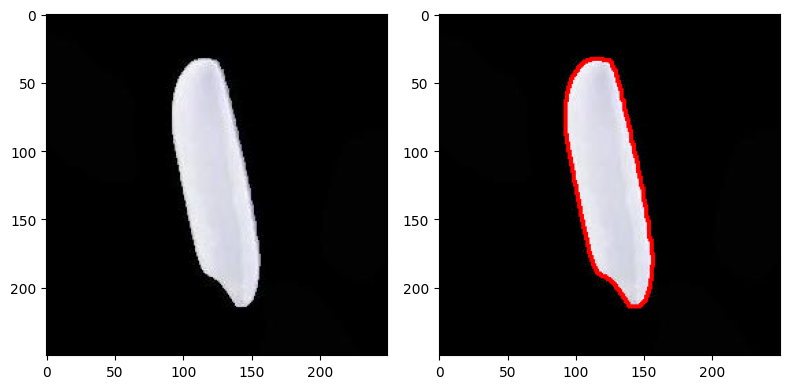

In [41]:
# determine contour for each image
all_contours = [] #create list to store contours

for img_path in subset: #loop through all images

    #find all contours and store to list
    img = cv.imread(img_path)
    assert img is not None, "file could not be read, check with os.path.exists()"
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) #grayscale image
    ret, thresh = cv.threshold(gray, 127, 255, 0) #applies threshold, gets a binary image
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) #find contours

    all_contours.append(contours)


# load test image and find contours
img = cv.imread(test_image) #read image
assert img is not None, "file could not be read, check with os.path.exists()"
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) #grayscale image
ret, thresh = cv.threshold(gray, 127, 255, 0) #applies threshold, gets a binary image
test_contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) #find contours

# draw contours and plot images
fig, axes = plt.subplots(1,2, figsize=(8,4)) #create figure

rgb_image = cv.cvtColor(img, cv.COLOR_BGR2RGB) #convert back to rgb
axes[0].imshow(rgb_image) #plot original image

rgb_image_copy = rgb_image #create copy of rgb image
cv.drawContours(rgb_image_copy, test_contours, -1, (255,0,0), 2) #draw contours on the copy
axes[1].imshow(rgb_image_copy) #plot copy with contours

plt.tight_layout()

## Feature extraction

Gather the color feature data (12 features): <br>

First, convert each RGB image to YCbCr-image. You can use *cvtColor* function from OpenCV with appropriate color conversion. <br>
Be aware that openCV default channel order is BGR not RGB. In which order does the *cvtColor* function output the components? <br>

Calculate the following color features for each image, including only the pixels within the contour (you can use *pointPolygonTest* from OpenCV)
- Mean for each YCbCr component
- Variance for each YCbCr component
- Skewness for each YCbCr component
- Kurtosis for each YCbCr component

In [5]:
# create lists for storage
Y_color_means = []
Y_color_vars = []
Y_color_skews = []
Y_color_kurts = []
Cb_color_means = []
Cb_color_vars = []
Cb_color_skews = []
Cb_color_kurts = []
Cr_color_means = []
Cr_color_vars = []
Cr_color_skews = []
Cr_color_kurts = []

# create function to calculate color features
def calculate_color_features(image, component, contours):

    # create a black mask with the same size as the image
    mask = np.zeros_like(image)

    for contour in contours:
        cv.drawContours(mask, [contour], 0, (255, 255, 255), thickness=cv.FILLED)

    # use the mask to extract the region of interest (ROI) from the image
    roi = cv.bitwise_and(image, mask)

    # calculate color features within the ROI
    color_mean = np.mean(roi[:, :, component], axis=(0, 1))
    color_var = np.var(roi[:, :, component], axis=(0, 1))
    color_skew = sp.skew(roi[:, :, component], axis=(0, 1))
    color_kurt = sp.kurtosis(roi[:, :, component], axis=(0, 1))

    return color_mean, color_var, color_skew, color_kurt


# find color features and save them to corresponding lists
for img_path, contours in zip(subset, all_contours):
    img = cv.imread(img_path)
    assert img is not None, "file could not be read, check with os.path.exists()"
    ycbcr_img = cv.cvtColor(img, cv.COLOR_BGR2YCrCb) #convert image
    
    color_mean, color_var, color_skew, color_kurt = calculate_color_features(ycbcr_img, 0,  contours) #calculate Y-features for image

    #save feature values in lists
    Y_color_means.append(color_mean)
    Y_color_vars.append(color_var)
    Y_color_skews.append(color_skew)
    Y_color_kurts.append(color_kurt)

    color_mean, color_var, color_skew, color_kurt = calculate_color_features(ycbcr_img, 1,  contours) #calculate Cb-features for image

    #save feature values in lists
    Cb_color_means.append(color_mean)
    Cb_color_vars.append(color_var)
    Cb_color_skews.append(color_skew)
    Cb_color_kurts.append(color_kurt)

    color_mean, color_var, color_skew, color_kurt = calculate_color_features(ycbcr_img, 2,  contours) #calculate Cr-features for image

    #save feature values in lists
    Cr_color_means.append(color_mean)
    Cr_color_vars.append(color_var)
    Cr_color_skews.append(color_skew)
    Cr_color_kurts.append(color_kurt)


Is point x = 125, y = 160 within the contour in the test_image? (x is in horizontal direction, y is in vertical direction)

In [45]:
# is point in contours
def is_point_in_contours(point, contours):
    return cv.pointPolygonTest(contours[0], point, False)

point = (125, 160)

if is_point_in_contours(point, test_contours) == 1:
    print(f"Point {point} is within the test image contours")
else:
    print(f"Point {point} is not within the test image contours")

Point (125, 160) is within the test image contours


What are the mean values of Y, Cb and Cr components for the test image (within the contour)?

In [8]:
# convert image
ycbcr_test_img = cv.cvtColor(rgb_image, cv.COLOR_RGB2YCrCb)

# calculate mean values of color components for the test image
Y_color_mean = calculate_color_features(ycbcr_test_img, 0, contours)[0]
Cb_color_mean = calculate_color_features(ycbcr_test_img, 1, contours)[0]
Cr_color_mean = calculate_color_features(ycbcr_test_img, 2, contours)[0]

print(f"The mean values of color components of the test image:\n\nY: {Y_color_mean}\nCb: {Cb_color_mean}\nCr: {Cr_color_mean}")

The mean values of color components of the test image:

Y: 11.807104
Cb: 14.233712
Cr: 13.360144


Gather the dimension feature data (8 features) <br>
- Fit an ellipse to the contour points (use *fitEllipse* from OpenCV)
- Plot one example image of each rice species including the fitted ellipse
- Calculate the following features for each image (for details, see the original article)
    - the major axis length the ellipse
    - the minor axis length of the ellipse
    - area inside the contour (use *contourArea* from OpenCV)
    - perimeter of the contour (use *arcLength* from OpenCV)
    - equivalent diameter
    - compactness
    - shape factor 1 (SF1)
    - shape factor 2 (SF2)
    
Calculate the dimension feature values for the test_image as well. What are the dimension feature values for the test_image?

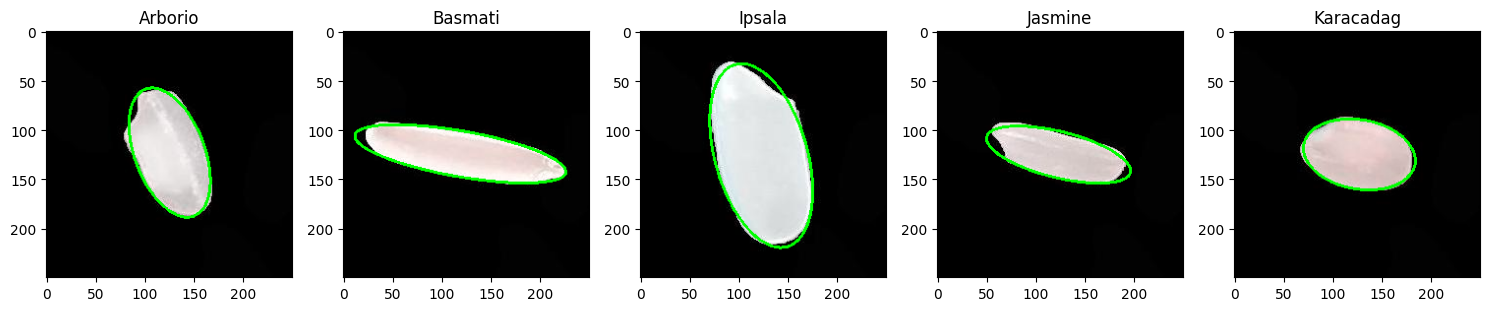

In [61]:
# create a list for ellipses
ellipses = []

# loop through images
for contours in all_contours:
    # fit ellipse to the contour
    ellipse = cv.fitEllipse(contours[0])
    ellipses.append(ellipse)


# create figure
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# draw example image for each rice species
j = 0
for i in range(0, 500, 100):
    image = cv.imread(subset[i])
    ellipse_image = cv.ellipse(image, ellipses[i], (0, 255, 0), 2) #draw ellipse onto image
    axes[j].imshow(ellipse_image)
    axes[j].set_title(folders[j])
    j += 1

plt.tight_layout()
    

In [90]:
# extract new variables based on ellipses

# major axis
major_axis = [ellipse[1][1] for ellipse in ellipses]

# minor axis
minor_axis = [ellipse[1][0] for ellipse in ellipses]

# area inside contour
contour_area = [cv.contourArea(contours[0]) for contours in all_contours]

# perimeter of contour
perimeter = [cv.arcLength(contours[0], closed=True) for contours in all_contours]

# equivalent diameter
equivalent_diameter = [((4*a)/np.pi)**0.5 for a in contour_area]

# compactness
compactness = [ed/l for ed, l in zip(equivalent_diameter, major_axis)]

# shape factor 1
sf1 = [l/a for l, a in zip(major_axis, contour_area)]

# shape factor 2
sf2 = [l/a for l, a in zip(minor_axis, contour_area)]

In [ ]:
# calculate new variables on the test image

Gather all the features in a dataframe: one sample in one row, including all feature values in columns. <br>
For each data point, include also information of the original image and the label (rice species). <br>
Save the data in training_data folder as a parquet file.

Determine the maximum variance of the Cr component for each rice species. Which rice species has the smallest value?

Determine the minimum equivalent diameter for each rice species. Which rice species has the largest value?

Determine the minimum, maximum and median equivalent diameter for Basmati rice samples. <br>
Compare the equivalent diameter value of the test_image to these values. <br>

Does a high value of compactness mean that the rice is rather round or thin?